In [1]:
!pip install japanize_matplotlib

     ---------------------------------------- 4.1/4.1 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for japanize_matplotlib, since package 'wheel' is not installed.
  Running setup.py install for japanize_matplotlib: started
  Running setup.py install for japanize_matplotlib: finished with status 'done'


**データの準備の練習**

In [14]:
import os
import math
import gzip
from time import sleep
from random import gauss
from itertools import product
import pickle
from datetime import datetime, timedelta, date
from urllib import request


import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from numpy import uint


with open("./bybit_BTCUSD_2022_3.pkl", mode="rb") as f:
    exec_data = pickle.load(f)

exec_data["timestamp"] = pd.to_datetime(exec_data["timestamp"], unit="s")
exec_data.set_index("timestamp", inplace=True)
exec_data.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,
2022-03-01,BTCUSD,Sell,9,43179.5,MinusTick,876d94ec-9f6a-528f-9648-55c6133e19d6,20843.224215,9,0.000208
2022-03-01,BTCUSD,Sell,3,43179.5,ZeroMinusTick,b94b11dc-7747-50c5-9590-a732ab859939,6947.741405,3,0.000069
2022-03-01,BTCUSD,Sell,2,43179.5,ZeroMinusTick,2c833623-2598-57fa-8408-92900ffdc90f,4631.827603,2,0.000046
2022-03-01,BTCUSD,Sell,1,43178.5,MinusTick,ce18bf17-3535-534d-8745-bafb1267de27,2315.967437,1,0.000023
2022-03-01,BTCUSD,Sell,1,43178.0,MinusTick,29f8b6bf-066f-59c2-83b5-fe63a3739954,2315.994256,1,0.000023


In [6]:
len(exec_data)

11921083

```python
データをタイムバーに変換する。
```

In [8]:
FREQ = "15min"

time_bar = pd.DataFrame(columns=["op", "hi", "lo", "cl", "volume"])
time_bar.index.name = "timestamp"

ohlc = exec_data["price"].resample(FREQ).ohlc()
volume = exec_data["size"].resample(FREQ).sum()
ohlcv = pd.concat([ohlc, volume], axis=1)
ohlcv.index.name = "timestamp"
ohlcv.columns = ["op", "hi", "lo" ,"cl", "volume"]

time_bar = pd.concat([time_bar, ohlcv], axis=0)

time_bar.head()

,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174


Text(0.5, 1.0, 'タイムバー')

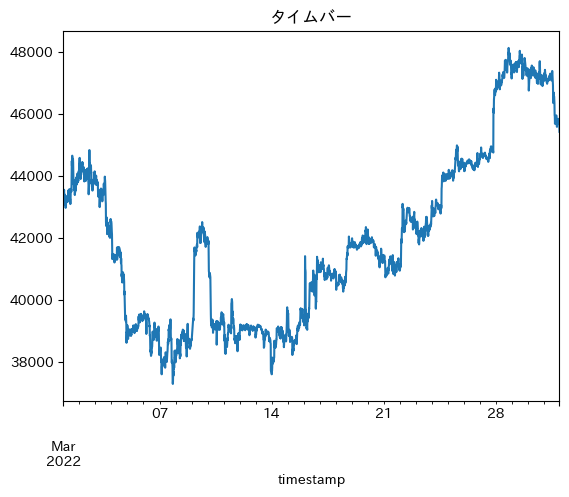

In [13]:
# time_bar[["op", "hi", "lo", "cl"]].plot()
time_bar["op"].plot()
plt.title("タイムバー")

### pandas-taを用いて指標を使ってみる

In [15]:
!pip install pandas-ta

     -------------------------------------- 115.1/115.1 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for pandas-ta, since package 'wheel' is not installed.
  Running setup.py install for pandas-ta: started
  Running setup.py install for pandas-ta: finished with status 'done'


In [16]:
import pandas_ta as ta

####  SMA(単純移動平均線)の実装

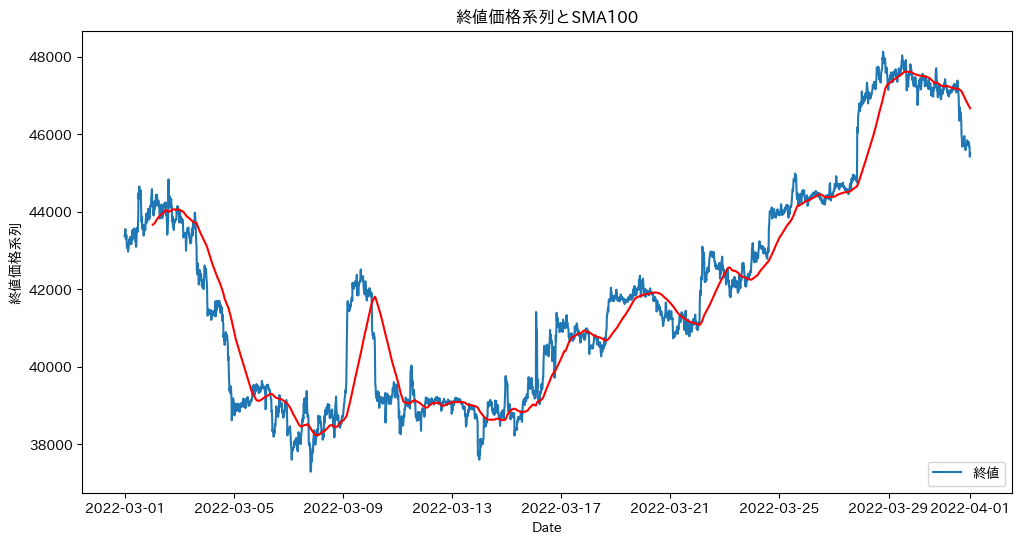

In [48]:
from cProfile import label


sma100 = ta.sma(time_bar["cl"], length=100)
sma100.dropna(inplace=True)

plt.figure(figsize=(12,6))
plt.title("終値価格系列とSMA100")

plt.plot(time_bar.index, time_bar.cl, label="終値")
plt.legend(loc='lower right')
plt.ylabel("終値価格系列", fontsize=10)
plt.xlabel("Date")

plt.plot(sma100, color="r", label="SMA")





### ボリンジャーバンド

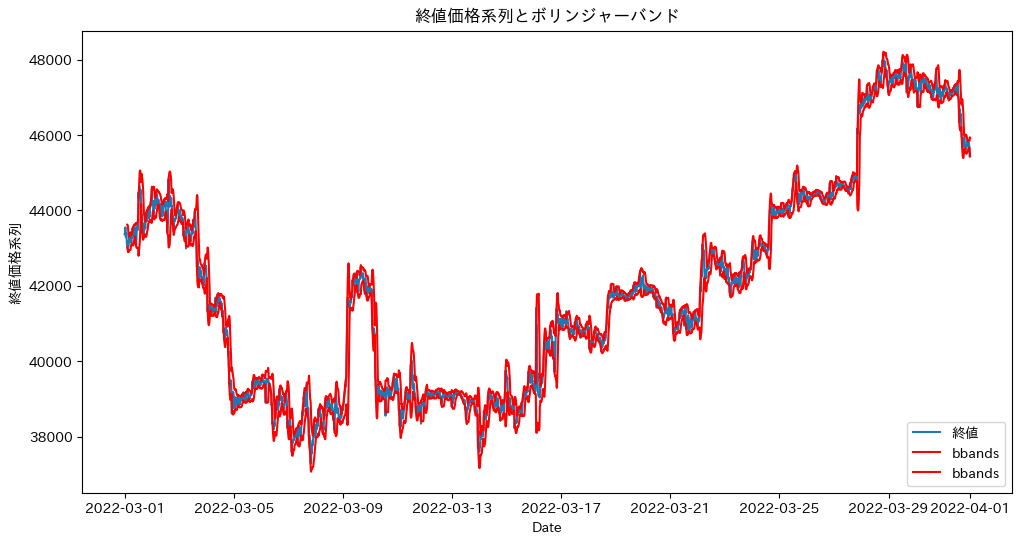

In [53]:
bbands = ta.bbands(time_bar.cl, length=10)
bbands.dropna(inplace=True)
bbands.drop(["BBP_10_2.0"], axis=1, inplace=True)
bbands.drop(["BBB_10_2.0"], axis=1, inplace=True)


plt.figure(figsize=(12,6))
plt.title("終値価格系列とボリンジャーバンド")

plt.plot(time_bar.index, time_bar.cl, label="終値")
plt.legend(loc="lower right")
plt.ylabel("終値価格系列", fontsize=10)
plt.xlabel("Date")

plt.plot(bbands['BBL_10_2.0'], color='r', label="bbands")
plt.plot(bbands['BBU_10_2.0'], color='r', label="bbands")
plt.legend(loc="lower right")

### 特徴量を増やす関数を作る。

In [55]:
def create_features(df: pd.DataFrame):

    # テクニカル指標を計算し、新たな列として追加する関数

    new_df = df.copy()
    close = new_df["cl"]

    new_df['SMA5'] = ta.sma(close, length=5)
    new_df['SMA10'] = ta.sma(close,length=10)
    new_df['SMA25'] = ta.sma(close,length=25)

    new_df['WMA5'] = ta.wma(close,length=5)
    new_df['WMA10'] = ta.wma(close,length=10)
    new_df['WMA25'] = ta.wma(close,length=25)

    new_df['EMA5'] = ta.ema(close,length=5)
    new_df['EMA10'] = ta.ema(close,length=10)
    new_df['EMA25'] = ta.ema(close,length=25)

    new_df['MOM7'] = ta.mom(close,length=7)

    new_df['ROC10'] = ta.roc(close,length=10)

    new_df['REG'] = ta.linreg(close,length=5)
    new_df['ATR'] = ta.atr(new_df['hi'], new_df['lo'], close, length=14)

    new_df['RSI5'] = ta.rsi(close,length=5)
    new_df['RSI10'] = ta.rsi(close,length=10)

    return new_df


In [57]:
X = create_features(time_bar)
X.head()

,op,hi,lo,cl,volume,SMA5,SMA10,SMA25,WMA5,WMA10,WMA25,EMA5,EMA10,EMA25,MOM7,ROC10,REG,ATR,RSI5,RSI10
timestamp,,,,,,,,,,,,,,,,,,,,
2022-03-01 00:00:00,43179.5,43593.0,43177.0,43367.0,39018957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:15:00,43367.0,43384.0,43198.5,43367.0,9372331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:30:00,43367.5,43541.5,43318.5,43524.5,22522912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 00:45:00,43524.5,43745.0,43341.5,43549.5,27202334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-01 01:00:00,43549.5,43620.0,43279.0,43294.0,13692174,43420.4,NaN,NaN,43422.833333,NaN,NaN,43420.4,NaN,NaN,NaN,NaN,43424.05,NaN,NaN,NaN


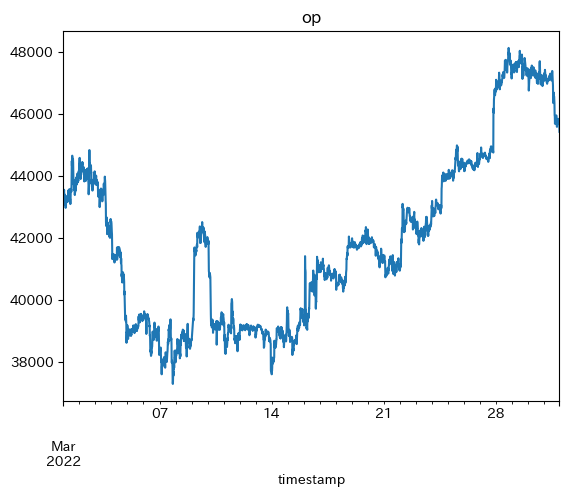

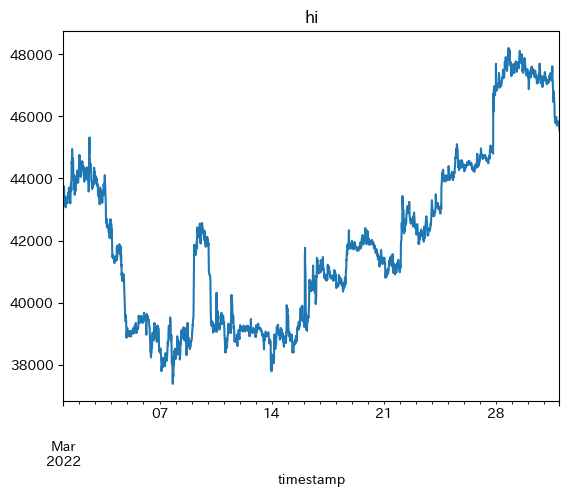

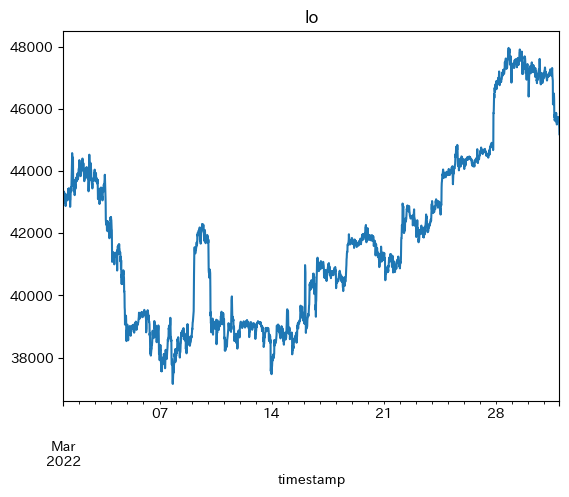

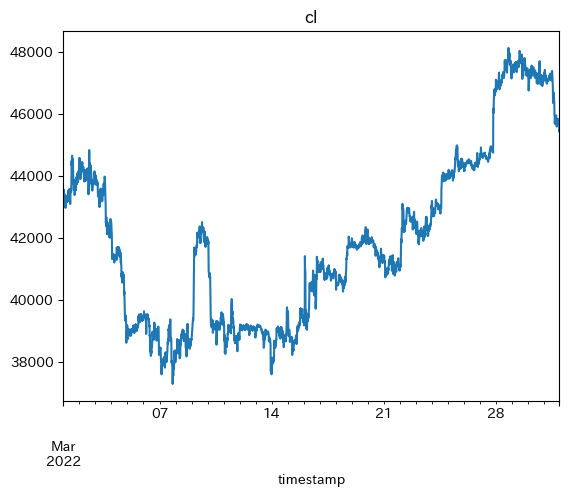

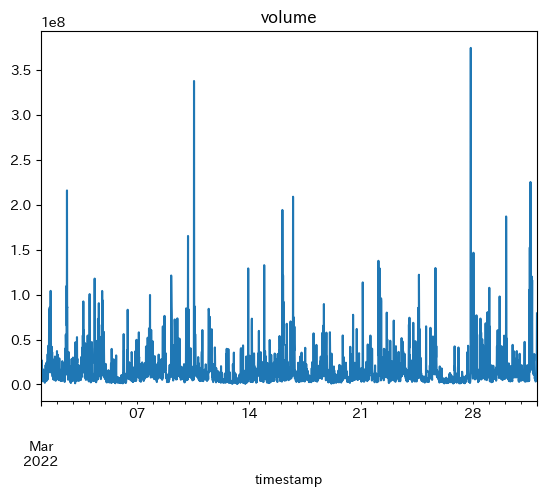

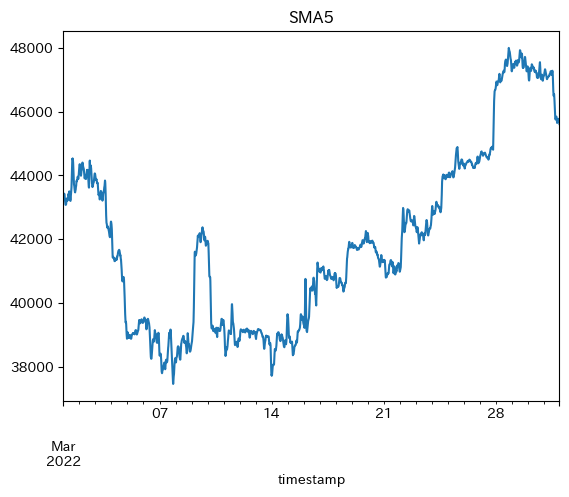

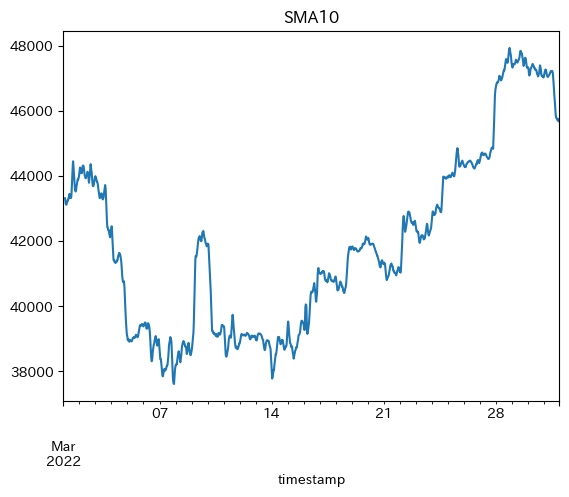

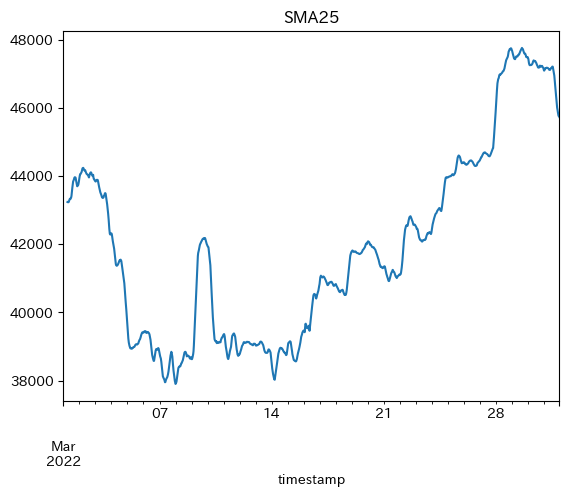

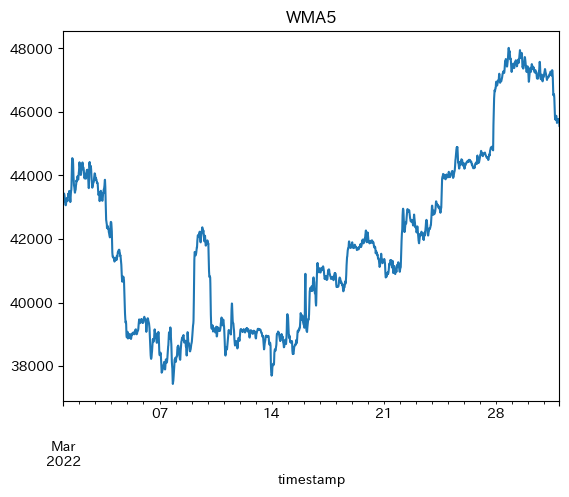

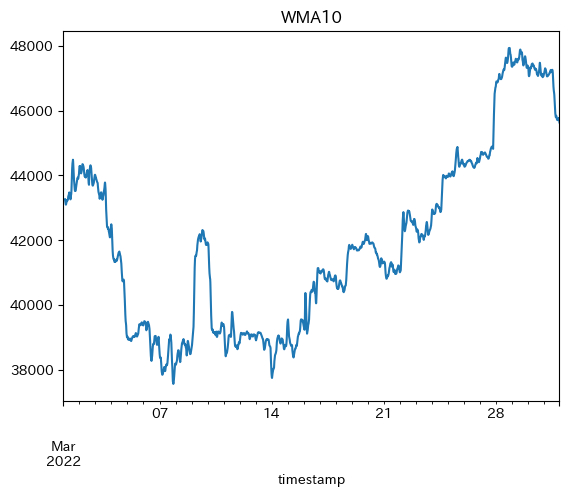

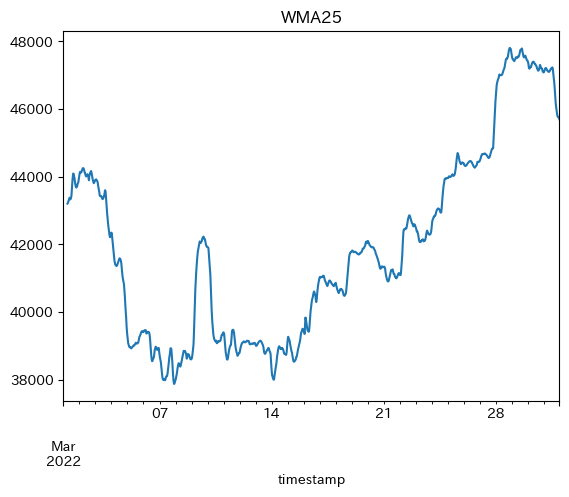

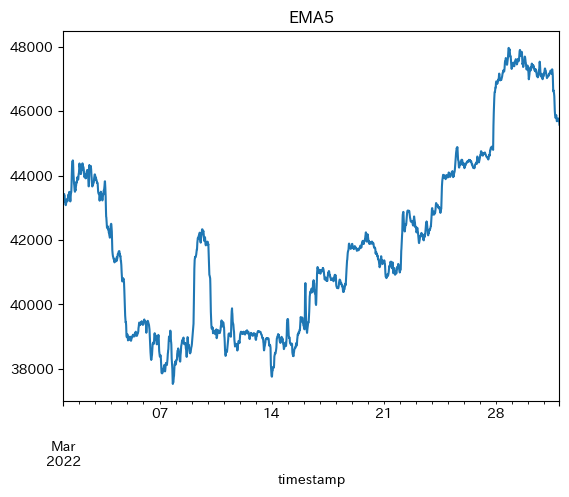

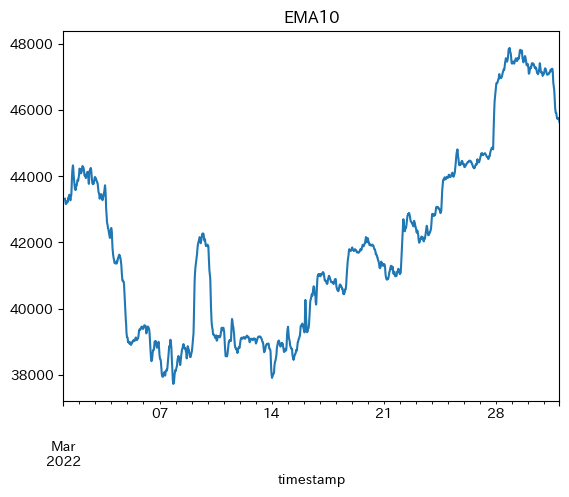

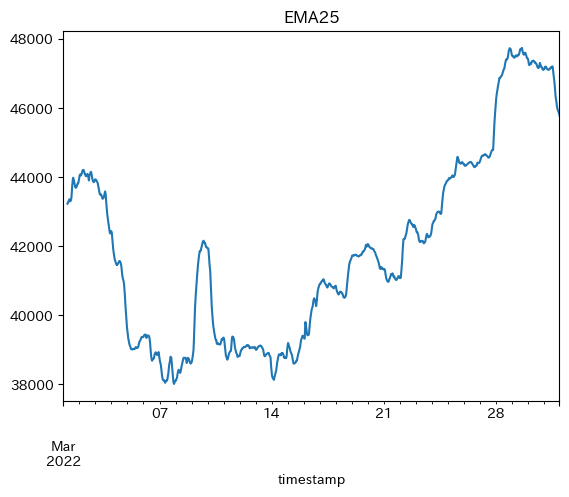

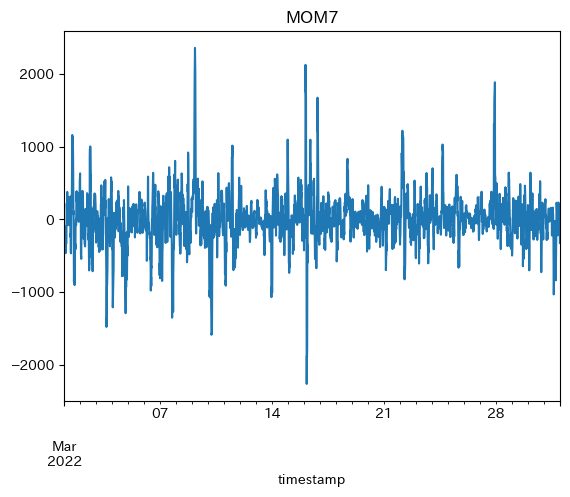

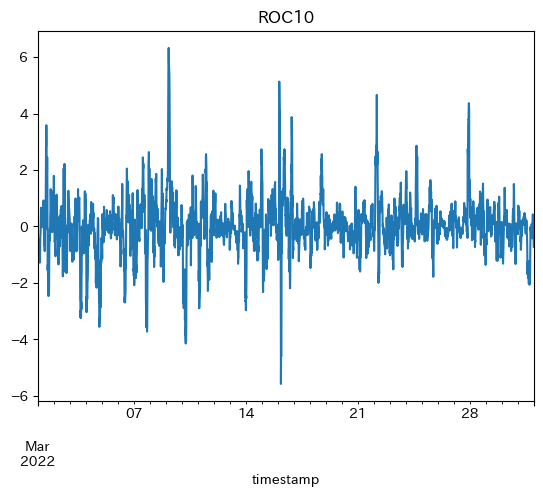

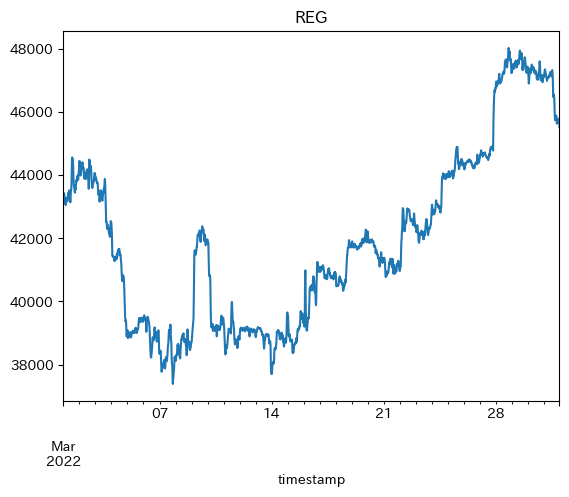

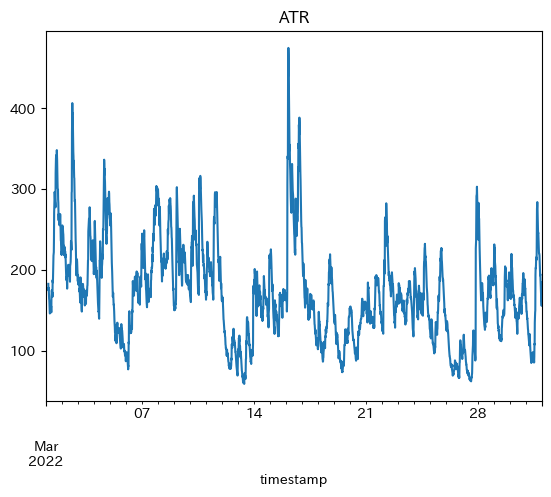

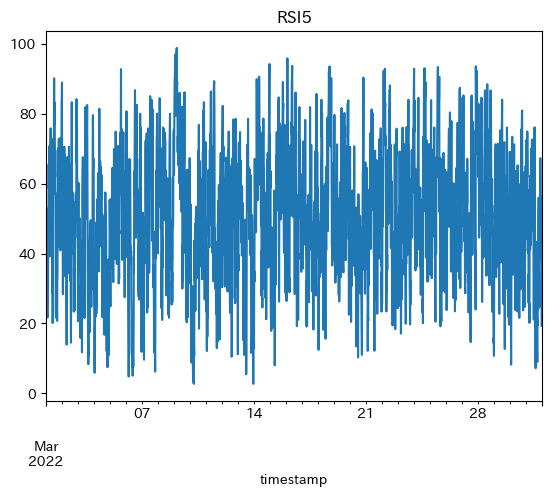

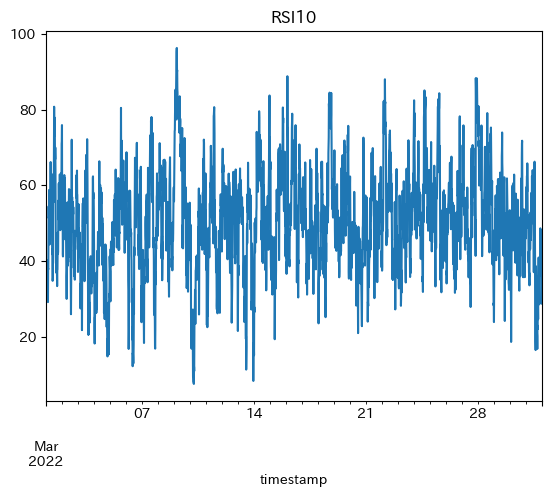

In [58]:
for col in X.columns:
    plt.title(col)
    X[col].plot()
    plt.show()